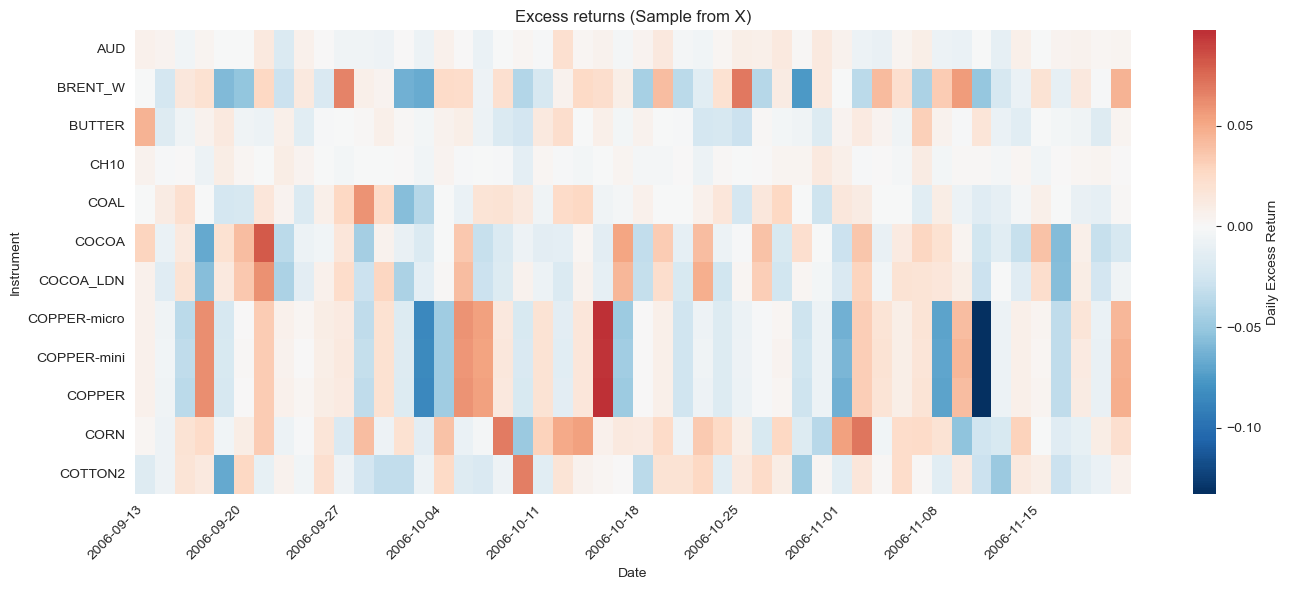

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

X = pd.read_parquet(
    r"C:\Users\Nikos\OneDrive - Birkbeck, University of London\1. Dissertation\Dissertation Python\zzz.Test\panels\X_large_universe\X_large_universe.parquet"
)

WINDOW_DAYS = 50
MAX_INSTR   = 12

rolling_counts = X.notna().rolling(WINDOW_DAYS).sum()
full_cols_per_end = (rolling_counts == WINDOW_DAYS).sum(axis=1)
best_end = full_cols_per_end.idxmax()
if pd.isna(best_end) or int(full_cols_per_end.loc[best_end]) == 0:
    raise RuntimeError("No contiguous window with full coverage found.")

best_start_pos = max(0, X.index.get_loc(best_end) - WINDOW_DAYS + 1)
best_start = X.index[best_start_pos]
window_mask = (X.index >= best_start) & (X.index <= best_end)
complete_in_window = rolling_counts.loc[best_end]
full_instruments = complete_in_window.index[complete_in_window == WINDOW_DAYS]
cols = list(full_instruments)[:MAX_INSTR]

subset = X.loc[window_mask, cols].copy()

if getattr(subset.index, "tz", None) is not None:
    subset.index = subset.index.tz_convert(None)
subset.index = subset.index.normalize()
labels = subset.index.strftime("%Y-%m-%d")

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    subset.T,
    cmap="RdBu_r",
    center=0,
    cbar_kws={'label': 'Daily Excess Return'}
)

n_days = subset.shape[0]
step = max(1, n_days // 10)
tick_positions = np.arange(0, n_days, step)
ax.set_xticks(tick_positions + 0.5)
ax.set_xticklabels(labels[::step], rotation=45, ha="right")

ax.set_xlabel("Date")
ax.set_ylabel("Instrument")
ax.set_title(f"Excess returns (Sample from X)")

plt.tight_layout()
plt.savefig("panel_snapshot_full_window.png", dpi=300)
plt.show()
